___

## Particle Prediction - Using Dense Neural Networks
#### DJ Dawkins, Nathan Deinlein, Joseph Lazarus, and Puri Rudick​

DS7333 QTW: Case Study 6
___

This Notebook will cover the following topics in order: 
1. Business Overview and Objectives
2. Data Evaluation and Engineering
3. Modeling Preparations and Model Building
4. Model Evaluation
5. Model Interpretability and Explainability
6. Conclusions and Discussions

In [3]:
# Imports necessary python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

---
### Business Overview and Objectives
The goal for this case study is to build a classification model using a dense neural network to distinguish between the existance of a new particle or not.

The goal is to maximize the accuracy and describe the decisions made while designing and building the network as well as determining when the model has sufficiently finished training. 

---
### Data Evaluation and Engineering

#### **Data Description:**
- There is a total of 7 million observations in the dataset.
- The dataset contains 28 features (named f0 to f26, and mass).  All features are numerical variables.
    - 22 of the features are continous variables.
    - 6 of the features; f5, f9, f13, f17, f21, and mass, are numerical categorical variables.
- The target variable is binary, called '# label' with 2 values: '0' for Non-Detection and '1' for Detection. The classes are balanced with the positve target value having a prevlaence of ~50%.
    - *3,499,121* observations for '0' or Non-Detection class
    - *3,500,879* observations for '1' or Detection class


In [42]:
# Read in data

# The file is 1.63GB, which is too big for Github
# Save the file locally and read in using the file's path

# path = 'C:/Users/puri.rudick/Downloads/all_train.csv.gz'
path = '/Users/puri/DataScience@SMU/10.DS7333 QTW/all_train.csv.gz'
# path = "C:/Users/OaklandHillsMansion/OneDrive - Southern Methodist University/SMU/DS 7333 Quantify World/QTW_Week11_Files/all_train.csv.gz"

df = pd.read_csv(path, compression='gzip', on_bad_lines='skip')

In [5]:
df.shape

(7000000, 29)

In [7]:
print(df.groupby(['# label'])['# label'].count())

# label
0.0    3499121
1.0    3500879
Name: # label, dtype: int64


#### **Exploratory Data Analysis (EDA)**

**Missing Values and Duplicated Rows**<br>
There is no missing value, and no duplicated rows.

**Statistical Summary Table** of the dataset as shown below.


In [8]:
# Count missing values
df_na = pd.DataFrame(df.isna().sum())
df_na.rename(columns={df_na.columns[0]: 'count'}, inplace = True)

df_na = df_na[df_na['count'] != 0]
df_na['percent_missing'] = df_na['count']/df.shape[0]
df_na = df_na.sort_values('count', ascending=False)

df_na

,count,percent_missing


In [9]:
# Check for duplicate rows
print('Duplicate rows: ', df.duplicated(keep='first').sum())

Duplicate rows:  0


In [6]:
df.describe()

,# label,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
count,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,...,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06
mean,5.001256e-01,1.612528e-02,4.770022e-04,2.686578e-05,1.056081e-02,-1.050026e-04,2.765919e-03,1.815953e-02,2.510948e-05,4.345870e-04,...,1.164789e-02,-1.127097e-04,7.686731e-05,2.909202e-04,1.228774e-02,9.778378e-03,5.269844e-03,-1.760961e-03,1.533136e-02,1.000107e+03
std,5.000000e-01,1.004417e+00,9.974864e-01,1.000080e+00,9.956003e-01,9.998670e-01,1.000957e+00,9.867746e-01,9.965867e-01,1.000007e+00,...,1.002725e+00,1.000038e+00,1.000033e+00,1.000170e+00,1.010477e+00,1.005418e+00,1.009990e+00,9.844511e-01,9.822799e-01,3.534255e+02
min,0.000000e+00,-1.960549e+00,-2.365355e+00,-1.732165e+00,-9.980274e+00,-1.732137e+00,-1.054221e+00,-3.034787e+00,-2.757853e+00,-1.732359e+00,...,-1.728284e+00,-2.281867e+00,-1.731758e+00,-5.736825e-01,-3.631608e+00,-4.729473e+00,-2.062223e+01,-3.452634e+00,-2.632761e+00,5.000000e+02
25%,0.000000e+00,-7.288206e-01,-7.332548e-01,-8.656704e-01,-6.092291e-01,-8.658025e-01,-1.054221e+00,-7.566092e-01,-7.014146e-01,-8.656543e-01,...,-7.423630e-01,-7.206846e-01,-8.656855e-01,-5.736825e-01,-5.417942e-01,-5.115522e-01,-3.543870e-01,-6.925097e-01,-7.943804e-01,7.500000e+02
50%,1.000000e+00,-3.930319e-02,8.523957e-04,3.199154e-04,1.963316e-02,-5.070131e-04,-5.983562e-03,-1.499527e-01,-1.067553e-04,1.384781e-03,...,-8.992496e-02,-6.735953e-05,-4.424527e-04,-5.736825e-01,-1.602760e-01,-3.144032e-01,-3.265228e-01,-3.570301e-01,-8.828640e-02,1.000000e+03
75%,1.000000e+00,6.900799e-01,7.347832e-01,8.659464e-01,6.798818e-01,8.657646e-01,8.504885e-01,7.686690e-01,7.013194e-01,8.665976e-01,...,6.423185e-01,7.204921e-01,8.659566e-01,-5.736825e-01,4.812194e-01,1.634892e-01,-2.337671e-01,4.753128e-01,7.610846e-01,1.250000e+03
max,1.000000e+00,4.378282e+00,2.365287e+00,1.732370e+00,4.148023e+00,1.731978e+00,4.482618e+00,3.720345e+00,2.758590e+00,1.731450e+00,...,5.866367e+00,2.282217e+00,1.732740e+00,1.743123e+00,7.293420e+00,9.333287e+00,1.499064e+01,5.277313e+00,4.444690e+00,1.500000e+03


**Data Distribution and Correlation**<br>

Data Observations from histograms and correlation heatmap:
- All 22 continous variables (everything except f5, f9, f13, f17, f21, and mass) take on either a normal-ish distribution or a uniform distribution
- For features f0, f3, f6, f10, f14, f18, and f26 the pos. and neg. classes appear to take on noticiably different shapes.<br>
- Feature f24 values for both pos and neg are predominantly 0.<br>
- However, when plot these features on box plots (below), we do not see any major shift between classes in the data.
- The correlation heatmap below clearly displays that there is no evidence of correlation was found among any of the features.<br>

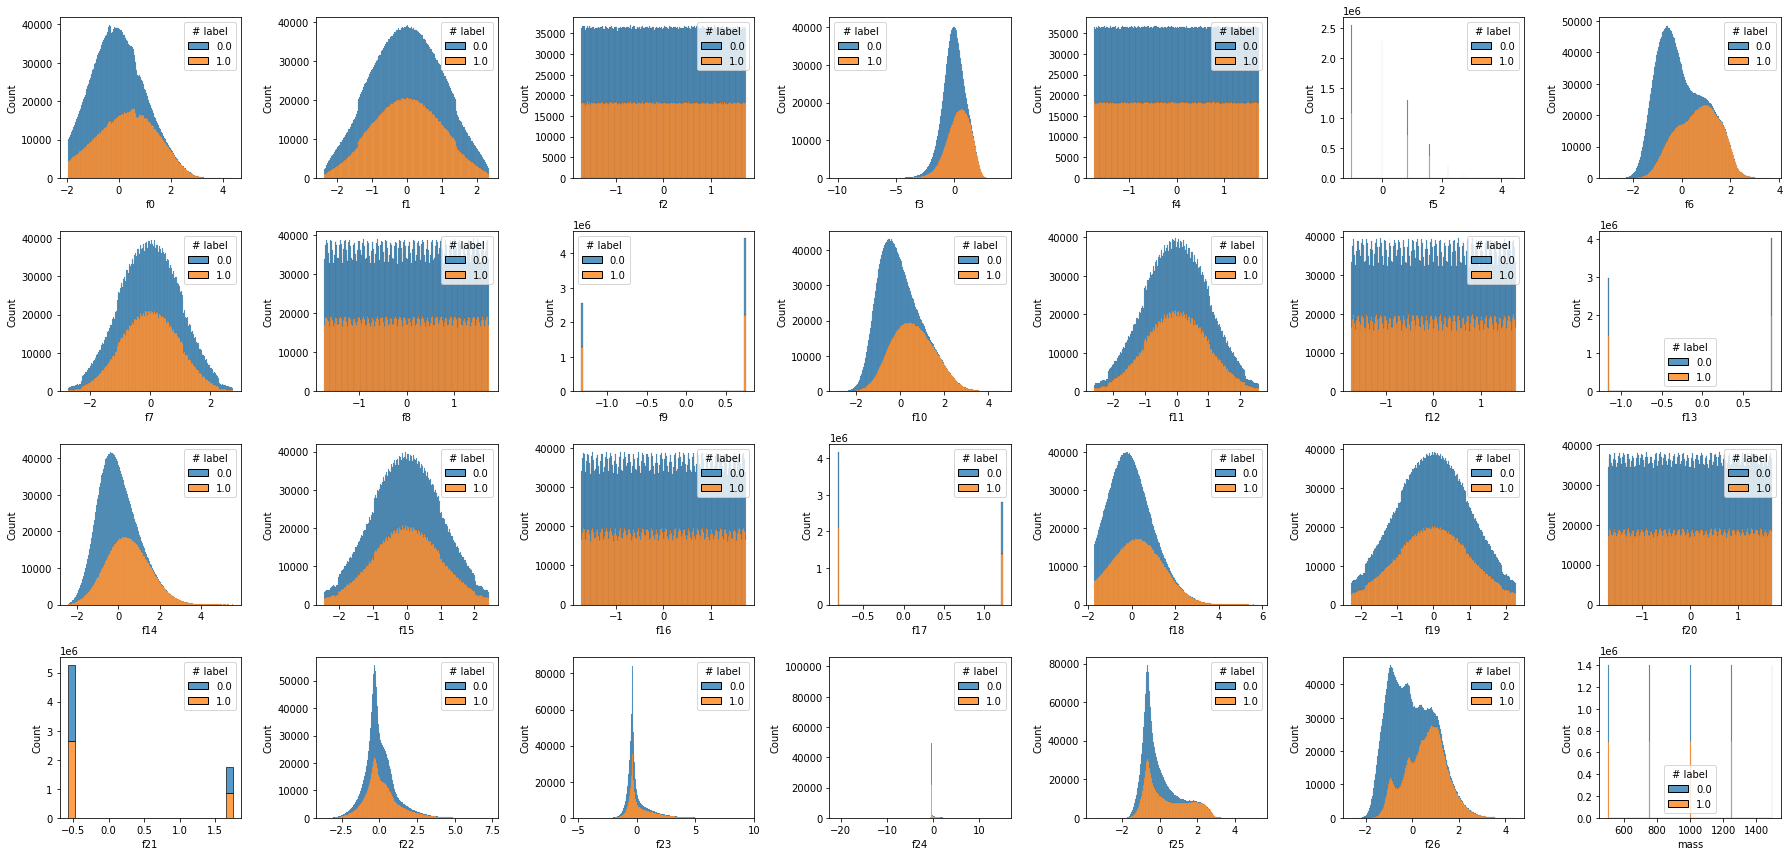

In [10]:
df_features = df.copy()
df_features.drop(["# label"], axis=1, inplace=True)

fig,axs = plt.subplots(4,7, figsize = (25,12))
h, v = 0, 0
for i in df_features.columns:
    sns.histplot(data=df, x=i, hue='# label', multiple='stack', ax=axs[h, v])
    if v == 6:
        h += 1
        v = -1
    v += 1
fig.tight_layout()


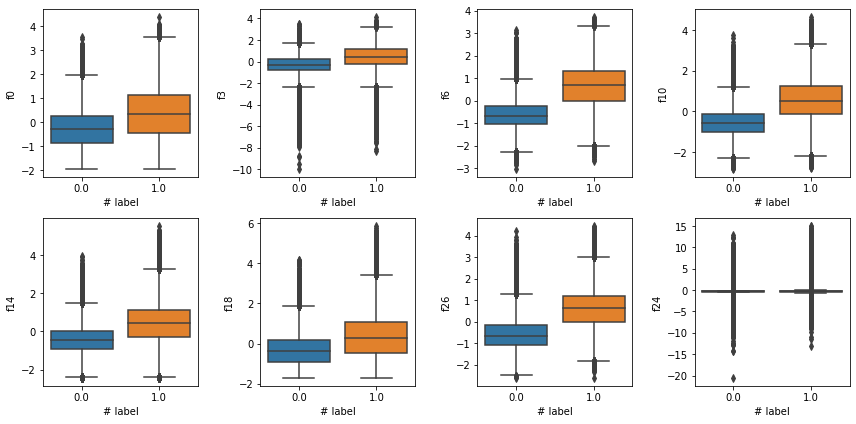

In [11]:
fig,axs = plt.subplots(2, 4, figsize = (12, 6))

sns.boxplot(data=df, x='# label', y='f0', ax=axs[0, 0])
sns.boxplot(data=df, x='# label', y='f3', ax=axs[0, 1])
sns.boxplot(data=df, x='# label', y='f6', ax=axs[0, 2])
sns.boxplot(data=df, x='# label', y='f10', ax=axs[0, 3])
sns.boxplot(data=df, x='# label', y='f14', ax=axs[1, 0])
sns.boxplot(data=df, x='# label', y='f18', ax=axs[1, 1])
sns.boxplot(data=df, x='# label', y='f26', ax=axs[1, 2])
sns.boxplot(data=df, x='# label', y='f24', ax=axs[1, 3])

fig.tight_layout()

<AxesSubplot:>

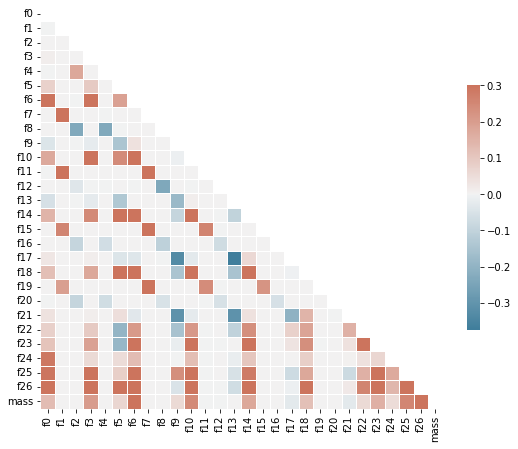

In [12]:
# Get correlation
corr = df_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

---
### Classification Models
<img src="https://miro.medium.com/max/1400/1*bhFifratH9DjKqMBTeQG5A.gif" style="float: right" width="700"/>

Dense neural networking models are appropriate for the problem becasue interpability is not a requirement and the dataset is 7 million rows, consisting of prodominetly continuous values.<br>
Also, per the objective of the assignment a Neural Network was requested and the data was deemed suitbale for the problem.<br>
To dfferentiate the usefullness of competing models the accuracy metric, since the target values are balanced, loss and model complexity were considered.<br>

To approach the objectives of this case study, we decided to use **Decision Tree Algorithm**. There are multiple advantages of the algorithm that we aould like to mention here:
- It can be used to solve both regression and classification problems.
- It requires less effort for data preparation during pre-processing. It does not require normalization of data as well.
- It is very intuitive and easy to explain to technical teams as well as stakeholders.
- Missing values in the data also do NOT affect the process of building a decision tree in some types of models.



There are 2 decision tree models that we are proposing for this classification:

#### **Random Forest**
The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each *individual tree* to try to create an *uncorrelated forest* of trees whose prediction by committee is more accurate than that of any individual tree.

In conclusion, Random forest is a collection of trees in which each of them gives a prediction and finally, we collect the outputs from all the trees and considers the mean, median, or mode of this collection as the prediction of this forest depending upon the nature of data (either continues or categorical).

#### **XGBoost** (eXtreme Gradient Boosting)
XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. XGBoost was developed to increase speed and performance, while introducing regularization parameters to reduce overfitting. Gradient boosted trees use regression trees (or CART) in a sequential learning process as weak learners.


###### *<div style="text-align: right">Image Credits: https://towardsdatascience.com/everything-you-need-to-know-about-neural-networks-and-backpropagation-machine-learning-made-easy-e5285bc2be3a</div>*

## Modeling Preparations 

Dense neural networking models are appropriate for the problem becasue interpability is not a requirement and the dataset is 7 million rows, consisting of prodominetly continuous values.<br>
Also, per the objective of the assignment a Neural Network was requested and the data was deemed suitbale for the problem.<br>
To dfferentiate the usefullness of competing models the accuracy metric, since the target values are balanced, loss and model complexity were considered.<br>

### Train Test Split

In [13]:
from sklearn.model_selection import train_test_split

model_data = df.copy()

feature_data = model_data.copy()
feature_data.drop(["# label"], axis=1, inplace=True)

target_data = model_data['# label']

# Splitted train and test dataset
X_train, X_test, y_train, y_test = train_test_split(feature_data,target_data,test_size=0.10,random_state=0)

print("Size of modeling set (to be CV split): ", X_train.shape)
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print("Size of hold back validation set: ", X_test.shape)
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

Size of modeling set (to be CV split):  (6300000, 28)
1.0    3150462
0.0    3149538
Name: # label, dtype: int64
1.0    0.500073
0.0    0.499927
Name: # label, dtype: float64
Size of hold back validation set:  (700000, 28)
1.0    350417
0.0    349583
Name: # label, dtype: int64
1.0    0.500596
0.0    0.499404
Name: # label, dtype: float64


### Fit & Transform

In [14]:
#Scale new predictor matrix
from sklearn.preprocessing import StandardScaler

scl_obj = StandardScaler()
scl_obj.fit(X_train)
X_train_ = scl_obj.transform(X_train)

scl_obj.fit(X_test)
X_test_ = scl_obj.transform(X_test)

### Set & Check Tensor Flow Configs

In [15]:
# TensorFlow and tf.keras
import tensorflow as tf
tf.random.set_seed(1234)

print(tf.__version__)

2.9.1


## Model Building & Evaluation

Six models were built and evaluated, and added more complexity with each proceeding model in efforts to improve the models performance. <br>
Adding more complexity to improve model performance does put your model at risk of overfitting.<br>
Overfitting was addressed during the model building phase by using regularization and dropout layers. <br>
During the evaluation phase overfitting was accounted for by evaluating the models accuracy and loss on the hold out set.<br>

### Metric Functions

In [30]:
# import keras.backend as K

# # define metrics
# def Recall(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def Precision(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def F1(y_true, y_pred):
#     precision = Precision(y_true, y_pred)
#     recall = Recall(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [48]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# This callback will stop the training when there is no improvement in the loss for three consecutive epochs.


def compile_and_fit(model, model_name, history_dict, test_df):

    # Compile and fit model
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    model_ = model.fit(X_train_, y_train, validation_split=0.1, epochs=100, batch_size=10000, verbose=0, callbacks=[callback])

    # Evaluate model
    e = model.evaluate(X_test_, y_test, batch_size=10000)

    # Add model name to evaluation object
    e.insert(0, model_name)

    # Convert eval into a df
    test_m = pd.DataFrame([e])
    test_m.columns = ['model','loss','acc']

    # Get model history
    history = model_.history

    # Add model history to the history dictionary
    history_dict[model_name] = history

    # Concat test matrix to the test df
    test_df = pd.concat([test_df, test_m])

    return model_.history, test_m, history_dict, test_df



In [49]:
models_histories = {}
test_matrices = pd.DataFrame()

In [50]:
# Model 1
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                      
])

h, t = compile_and_fit(model1, 'Model 1', models_histories, test_matrices)


70/70 [==============================] - 0s 6ms/step - loss: 0.2814 - accuracy: 0.8712


In [52]:
t

,model,loss,acc
0,Model 1,0.281369,0.871187


In [53]:
# Model 2
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t, _, _ = compile_and_fit(model2, 'Model 2', models_histories, test_matrices)

In [21]:
# Model 3
model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(8, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t, _, _ = compile_and_fit(model3, 'Model 3', models_histories, test_matrices)
models_histories['Model 3'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 0s 6ms/step - loss: 0.2620 - accuracy: 0.8817 - F1: 0.8839


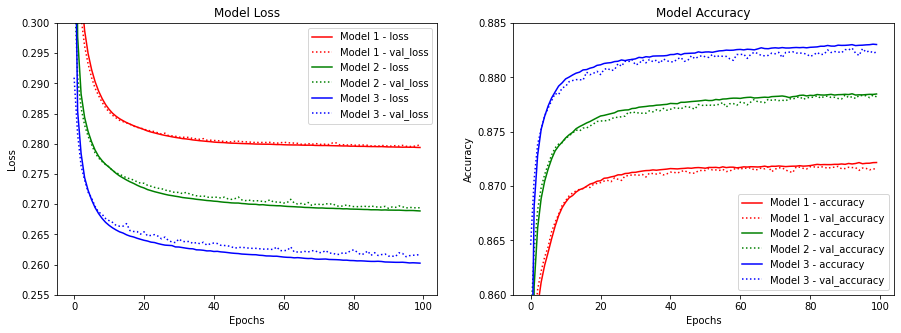

In [22]:
# plot
loss = ['loss', 'val_loss']
acc = ['accuracy', 'val_accuracy']
colors = ['red', 'green', 'blue']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## model1_    
ax[0].set(title="Model Loss")     
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')
ax[0].set_ylim(0.255, 0.3)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for l in loss:
        if "val" in l: 
            line='dotted'
        else:
            line='solid'
        ax[0].plot(models_histories[m][l], label=m+' - '+l, linestyle=line, color=c)
ax[0].legend()


ax[1].set(title="Model Accuracy")     
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Accuracy', color='black')
ax[1].set_ylim(0.86, 0.885)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for a in acc:
        if "val" in a: 
            line='dotted'
        else:
            line='solid'
        ax[1].plot(models_histories[m][a], label=m+' - '+a, linestyle=line, color=c)
ax[1].legend()
        

---
## Models 4 & 5

In [23]:
# Model 4
model4 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(32, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])


h, t, _, _ = compile_and_fit(model4, 'Model 4', models_histories, test_matrices)
models_histories['Model 4'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 0s 5ms/step - loss: 0.2744 - accuracy: 0.8773 - F1: 0.8825


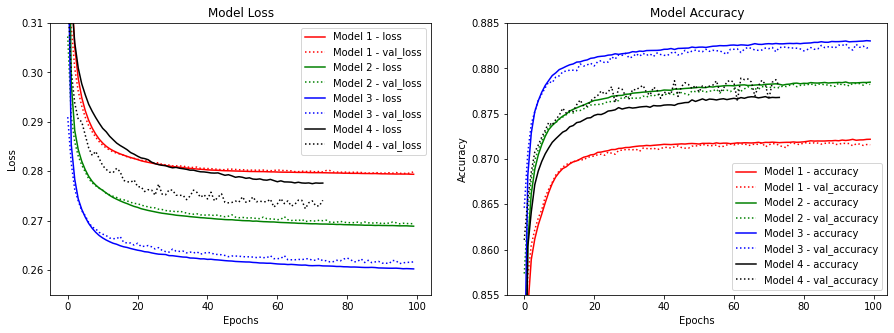

In [24]:
# plot
loss = ['loss', 'val_loss']
acc = ['accuracy', 'val_accuracy']
colors = ['red', 'green', 'blue', 'black']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## model1_    
ax[0].set(title="Model Loss")     
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')
ax[0].set_ylim(0.255, 0.31)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for l in loss:
        if "val" in l: 
            line='dotted'
        else:
            line='solid'
        ax[0].plot(models_histories[m][l], label=m+' - '+l, linestyle=line, color=c)
ax[0].legend()


ax[1].set(title="Model Accuracy")     
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Accuracy', color='black')
ax[1].set_ylim(0.855, 0.885)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for a in acc:
        if "val" in a: 
            line='dotted'
        else:
            line='solid'
        ax[1].plot(models_histories[m][a], label=m+' - '+a, linestyle=line, color=c)
ax[1].legend()
        

In [25]:
# Model 5
model5 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t, _, _ = compile_and_fit(model5, 'Model 5', models_histories, test_matrices)

70/70 [==============================] - 0s 7ms/step - loss: 0.2897 - accuracy: 0.8713 - F1: 0.8765


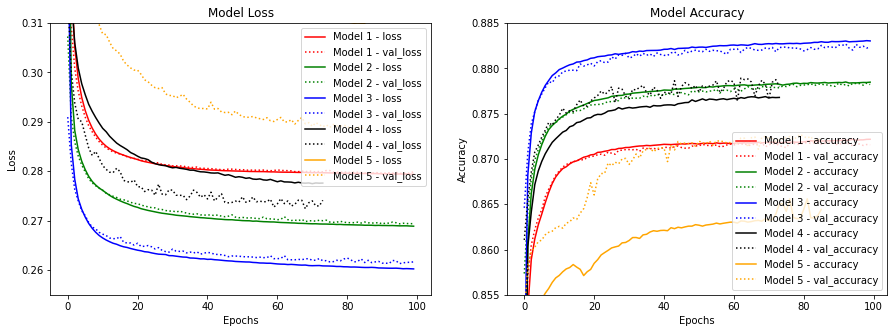

In [26]:
# plot
loss = ['loss', 'val_loss']
acc = ['accuracy', 'val_accuracy']
colors = ['red', 'green', 'blue', 'black', 'orange']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## model1_    
ax[0].set(title="Model Loss")     
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')
ax[0].set_ylim(0.255, 0.31)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for l in loss:
        if "val" in l: 
            line='dotted'
        else:
            line='solid'
        ax[0].plot(models_histories[m][l], label=m+' - '+l, linestyle=line, color=c)
ax[0].legend()


ax[1].set(title="Model Accuracy")     
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Accuracy', color='black')
ax[1].set_ylim(0.855, 0.885)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for a in acc:
        if "val" in a: 
            line='dotted'
        else:
            line='solid'
        ax[1].plot(models_histories[m][a], label=m+' - '+a, linestyle=line, color=c)
ax[1].legend()
        

In [28]:
# Model 6
model6 = tf.keras.Sequential([
    tf.keras.layers.Dense(36, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(16, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t, _, _ = compile_and_fit(model6, 'Model 6', models_histories, test_matrices)

70/70 [==============================] - 0s 4ms/step - loss: 0.2788 - accuracy: 0.8736 - F1: 0.8775


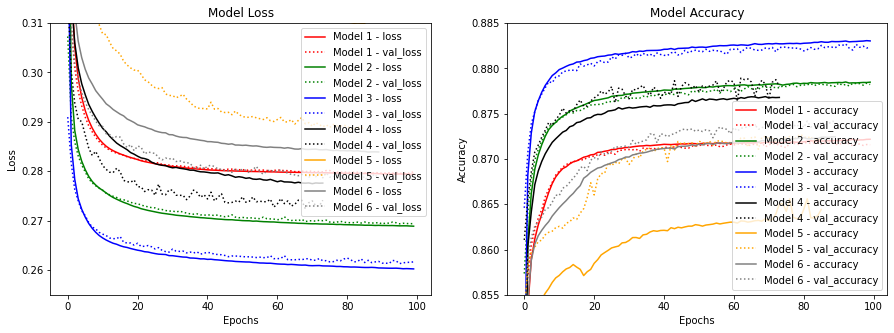

In [29]:
# plot
loss = ['loss', 'val_loss']
acc = ['accuracy', 'val_accuracy']
colors = ['red', 'green', 'blue', 'black', 'orange', 'grey']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## model1_    
ax[0].set(title="Model Loss")     
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')
ax[0].set_ylim(0.255, 0.31)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for l in loss:
        if "val" in l: 
            line='dotted'
        else:
            line='solid'
        ax[0].plot(models_histories[m][l], label=m+' - '+l, linestyle=line, color=c)
ax[0].legend()


ax[1].set(title="Model Accuracy")     
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Accuracy', color='black')
ax[1].set_ylim(0.855, 0.885)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for a in acc:
        if "val" in a: 
            line='dotted'
        else:
            line='solid'
        ax[1].plot(models_histories[m][a], label=m+' - '+a, linestyle=line, color=c)
ax[1].legend()
        